In [3]:
import os
import pandas as pd
import numpy as np
from pathlib import Path

# Adjust paths to your setup
DATA_DIR_CSV = Path("/mnt/c/Users/orizarchi/Desktop/Courses/Resting_ECG_Dataset/dat_csv")
DATA_DIR_ANN = Path("/mnt/c/Users/orizarchi/Desktop/Courses/Resting_ECG_Dataset/ann_txt")
OUT_DIR = Path("~/projects/ecg_delineation/data/processed/segments").expanduser()
OUT_DIR.mkdir(parents=True, exist_ok=True)

In [4]:
FS = 500  # Hz
SEG_LEFT = 193   # samples left of QRS center
SEG_RIGHT = 318  # samples right of QRS center
SEG_LEN = SEG_LEFT + 1 + SEG_RIGHT  # = 512


In [5]:
# Helper functions

def load_signal(record_id):
    """Load full 12-lead ECG from CSV as numpy array [12, N]."""
    sig_path = DATA_DIR_CSV / f"{record_id}.csv"
    sig = pd.read_csv(sig_path, header=None).values.T
    return sig  # shape [12, length]

def load_annotations(record_id, lead_suffix):
    """Load annotations for a single lead as DataFrame."""
    anno_path = DATA_DIR_ANN / f"{record_id}.{lead_suffix}.txt"
    if not anno_path.exists():
        return None
    anno = pd.read_csv(
        anno_path, skiprows=1, header=None,
        names=["type", "start", "end"],
        dtype={"type": int, "start": int, "end": int}
    )
    return anno

def segment_around_qrs(sig, anno):
    """
    Segment signal around QRS centers.
    Args:
        sig: numpy array [length] for one lead
        anno: DataFrame with columns [type,start,end]
    Returns:
        segments: list of arrays [SEG_LEN]
        labels: list of arrays [SEG_LEN] with values {0=P,1=QRS,2=T,3=bg}
    """
    segments, labels = [], []
    qrs = anno[anno["type"] == 1]  # QRS rows

    for _, row in qrs.iterrows():
        center = (row["start"] + row["end"]) // 2
        start = center - SEG_LEFT
        end = center + SEG_RIGHT

        # pad if segment exceeds boundaries
        pad_left = max(0, -start)
        pad_right = max(0, end - (len(sig) - 1))
        start_clipped = max(0, start)
        end_clipped = min(len(sig) - 1, end)

        seg = np.zeros(SEG_LEN, dtype=np.float32)
        seg[pad_left:SEG_LEN-pad_right] = sig[start_clipped:end_clipped+1]

        # build label vector
        label_vec = np.full(SEG_LEN, 3, dtype=np.int64)  # default = background
        for _, wave in anno.iterrows():
            # mark overlap of wave interval with this segment
            w_start = wave["start"] - start
            w_end = wave["end"] - start
            w_start = max(0, w_start)
            w_end = min(SEG_LEN-1, w_end)
            if w_end >= 0 and w_start < SEG_LEN:
                label_vec[w_start:w_end+1] = wave["type"]

        segments.append(seg)
        labels.append(label_vec)

    return segments, labels

Extracted 15 beats from AF0091.ii


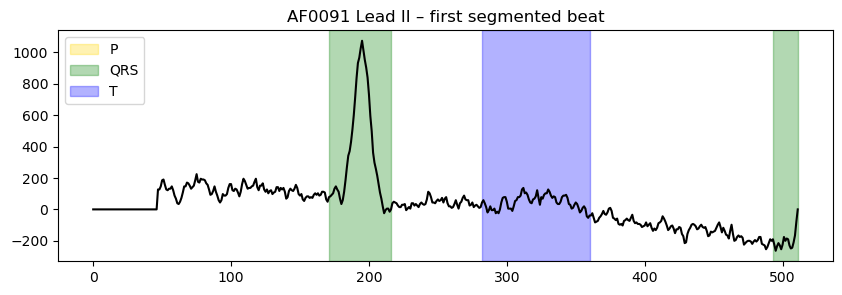

In [11]:
# Run one example (preview)

record_id = "AF0091"  # try one file
lead_suffix = "ii"    # lead II

sig = load_signal(record_id)[1]  # column 1 = lead II
anno = load_annotations(record_id, lead_suffix)
segments, labels = segment_around_qrs(sig, anno)

print(f"Extracted {len(segments)} beats from {record_id}.{lead_suffix}")

# Quick check: plot first segment
import matplotlib.pyplot as plt
plt.figure(figsize=(10,3))
plt.plot(segments[0], color="black")
plt.fill_between(range(SEG_LEN), 0, 1, where=labels[0]==0, color="gold", alpha=0.3, transform=plt.gca().get_xaxis_transform(), label="P")
plt.fill_between(range(SEG_LEN), 0, 1, where=labels[0]==1, color="green", alpha=0.3, transform=plt.gca().get_xaxis_transform(), label="QRS")
plt.fill_between(range(SEG_LEN), 0, 1, where=labels[0]==2, color="blue", alpha=0.3, transform=plt.gca().get_xaxis_transform(), label="T")
plt.title(f"{record_id} Lead II – first segmented beat")
plt.legend()
plt.show()


In [12]:
# Process whole dataset and save
import pickle

def process_and_save(record_id, lead_suffix="ii"):
    sig = load_signal(record_id)[1]  # lead II only for now
    anno = load_annotations(record_id, lead_suffix)
    if anno is None:
        return 0
    segments, labels = segment_around_qrs(sig, anno)
    if not segments:
        return 0

    out_file = OUT_DIR / f"{record_id}_{lead_suffix}.pkl"
    with open(out_file, "wb") as f:
        pickle.dump({"segments": segments, "labels": labels}, f)
    return len(segments)

# Example: loop over a few records
record_ids = ["AF0001", "AF0002", "SR0001"]
for rid in record_ids:
    n = process_and_save(rid, "ii")
    print(f"{rid}: saved {n} beats")


AF0001: saved 16 beats
AF0002: saved 15 beats
SR0001: saved 12 beats
